In [1]:
%pip install pandas
%pip install matplotlib
%pip install codebleu
%pip install tree_sitter_python==0.21
%pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tree_sitter_python==0.21 (from versions: 0.23.0, 0.23.1, 0.23.2, 0.23.3, 0.23.4, 0.23.5, 0.23.6)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for tree_sitter_python==0.21
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from codebleu import calc_codebleu


### COMMON METHODS

In [4]:
def create_question_id_map(file):
    df = pd.read_json(file)
    question_id_map = {row['question_id']: row for _, row in df.iterrows()}
    return question_id_map

REFERENCE_FILE_RT_EFF = "/Users/vrucodes/CodeRefineAI/dataset/P1/balanced_samples_reference_rt_eff_submissions.json"
REFERENCE_FILE_RT_INEFF = "/Users/vrucodes/CodeRefineAI/dataset/P1/balanced_samples_reference_rt_ineff_submissions.json"
MASTER_MAP = create_question_id_map("/Users/vrucodes/CodeRefineAI/dataset/P1/balanced_samples.json")

In [5]:

def get_normalized_df(file):
    df = pd.read_json(file)
    tmp_df = pd.json_normalize(df['submission_details'])
    df = df.drop(columns=['submission_details']).join(tmp_df, rsuffix='_details')
    return df

def get_diff(codegen_file: str, reference_file: str):
    codegen_df = get_normalized_df(codegen_file)
    reference_df = get_normalized_df(reference_file)


    # Filter accepted solutions
    codegen_accepted = codegen_df[codegen_df['status.description'] == 'Accepted']
    reference_accepted = reference_df[reference_df['status.description'] == 'Accepted']

    # Initialize lists to store results
    rt_faster_solutions = []
    more_memory_efficient_solutions = []

    # Compare performance for each question
    for question_id in codegen_accepted['question_id'].unique():
        codegen_solution = codegen_accepted[codegen_accepted['question_id'] == question_id]
        reference_solution = reference_accepted[reference_accepted['question_id'] == question_id]
        
        if not codegen_solution.empty and not reference_solution.empty:
            master_row = MASTER_MAP.get(question_id)
            codegen_runtime = codegen_solution['time'].values[0]
            reference_runtime = reference_solution['time'].values[0]
            codegen_memory = codegen_solution['memory'].values[0]
            reference_memory = reference_solution['memory'].values[0]
            topics = master_row['topics'][0]
            difficulty = master_row['difficulty']
            
            # Determine which solution is faster
            if codegen_runtime < reference_runtime:
                rt_faster_solutions.append((
                    question_id, 
                    'codegen',
                    codegen_runtime, 
                    reference_runtime, 
                    topics,
                    difficulty
                ))
            else:
                rt_faster_solutions.append((
                    question_id, 
                    'reference', 
                    codegen_runtime, 
                    reference_runtime,
                    topics,
                    difficulty
                ))
            
            # Determine which solution is more memory efficient
            if codegen_memory < reference_memory:
                more_memory_efficient_solutions.append((
                    question_id, 
                    'codegen', 
                    codegen_memory, 
                    reference_memory,
                    topics,
                    difficulty
                ))
            else:
                more_memory_efficient_solutions.append((
                    question_id, 
                    'reference', 
                    codegen_memory, 
                    reference_memory,
                    topics,
                    difficulty
                ))
    
    
    rt_faster_solutions_df = pd.DataFrame(rt_faster_solutions, columns=['question_id', 'faster_solution', 'codegen_runtime', 'reference_runtime','topics','difficulty'])
    more_memory_efficient_solutions_df = pd.DataFrame(more_memory_efficient_solutions, columns=['question_id', 'more_memory_efficient_solution', 'codegen_memory', 'reference_memory','topics','difficulty'])
    
    percentage_runtime_faster_solutions = ((rt_faster_solutions_df["faster_solution"] == "codegen").sum() / len(rt_faster_solutions)) * 100
    percentage_memory_faster_solutions = ((more_memory_efficient_solutions_df["more_memory_efficient_solution"] == "codegen").sum() / len(more_memory_efficient_solutions)) * 100
    
    # Categorize by topics and difficulty
    categorized_rt_faster_solutions_by_topics = rt_faster_solutions_df.groupby(['topics']).apply(lambda x: (x['faster_solution'] == 'codegen').sum() / len(x) * 100).reset_index(name='percentage_runtime_faster_solutions')
    categorized_rt_faster_solutions_by_difficulty = rt_faster_solutions_df.groupby(['difficulty']).apply(lambda x: (x['faster_solution'] == 'codegen').sum() / len(x) * 100).reset_index(name='percentage_runtime_faster_solutions')
    categorized_memory_faster_solutions_by_topics = more_memory_efficient_solutions_df.groupby(['topics']).apply(lambda x: (x['more_memory_efficient_solution'] == 'codegen').sum() / len(x) * 100).reset_index(name='percentage_memory_faster_solutions')
    categorized_memory_faster_solutions_by_difficulty = more_memory_efficient_solutions_df.groupby(['difficulty']).apply(lambda x: (x['more_memory_efficient_solution'] == 'codegen').sum() / len(x) * 100).reset_index(name='percentage_memory_faster_solutions')
    
    #TODO add code similarity metrics
    return {
        "rt_faster_solutions_df": rt_faster_solutions_df,
        "more_memory_efficient_solutions_df": more_memory_efficient_solutions_df,
        "percentage_runtime_faster_solutions": percentage_runtime_faster_solutions,
        "percentage_memory_faster_solutions": percentage_memory_faster_solutions,
        "categorized_rt_faster_solutions_by_topics": categorized_rt_faster_solutions_by_topics,
        "categorized_rt_faster_solutions_by_difficulty": categorized_rt_faster_solutions_by_difficulty,
        "categorized_memory_faster_solutions_by_topics": categorized_memory_faster_solutions_by_topics,
        "categorized_memory_faster_solutions_by_difficulty": categorized_memory_faster_solutions_by_difficulty
    }

def get_submission_status_charts(df: pd.DataFrame, title:str= 'Distribution of Status Descriptions'):
    status_counts = df['status.description'].value_counts()
    plt.figure(figsize=(10, 6))
    status_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
    plt.title(title)
    plt.ylabel('') 
    plt.show()
    
def analyze_runtime_errors(df,threshold=1):
    # Define common Python errors
    python_errors = [
        "SyntaxError", "IndentationError", "TypeError", "NameError", "IndexError", "KeyError",
        "AttributeError", "ValueError", "ImportError", "ModuleNotFoundError", "ZeroDivisionError",
        "FileNotFoundError", "IOError", "EOFError", "RuntimeError", "RecursionError",
        "NotImplementedError", "AssertionError", "MemoryError", "OverflowError",
        "StopIteration", "UnboundLocalError", "PermissionError", "TimeoutError"
    ]

    # Filter runtime errors
    runtime_errors = df[df['status.description'] == 'Runtime Error (NZEC)']
    pd.set_option('display.max_colwidth', None)
    runtime_errors = runtime_errors[["question_id", "title", "stderr"]]

    # Count occurrences of each error
    error_counts = {error: runtime_errors['stderr'].str.contains(rf"\b{error}\b", na=False).sum() for error in python_errors}

    # Convert error counts into a DataFrame
    error_df = pd.DataFrame(list(error_counts.items()), columns=["Error Type", "Count"])
    error_df = error_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

    # Categorize errors: keep major ones, group smaller ones as "Others"
    filtered_errors = {err: count for err, count in error_counts.items() if count > threshold}
    others_count = sum(count for _, count in error_counts.items() if count <= threshold)

    # Add "Others" category if applicable
    if others_count > 0:
        filtered_errors["Others"] = others_count

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(filtered_errors.values(), labels=filtered_errors.keys(), autopct="%1.1f%%", startangle=140)
    plt.title("Distribution of Python Errors in stderr")
    plt.show()

    return error_df

## ANALYSIS FOR SELF-FEEDBACK REfINEMENT 3

### GEMINI ANALYSIS

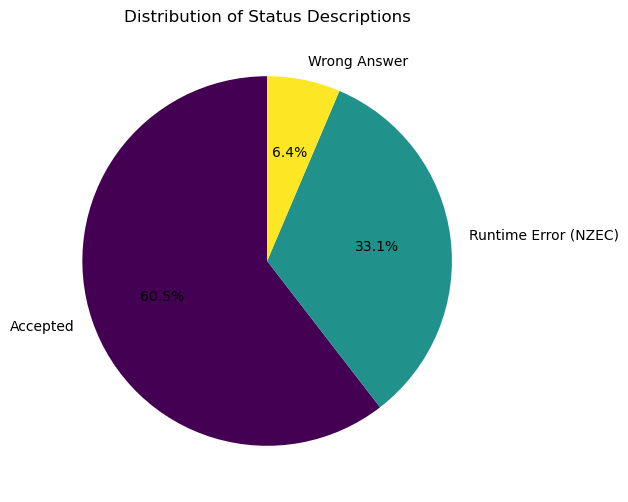

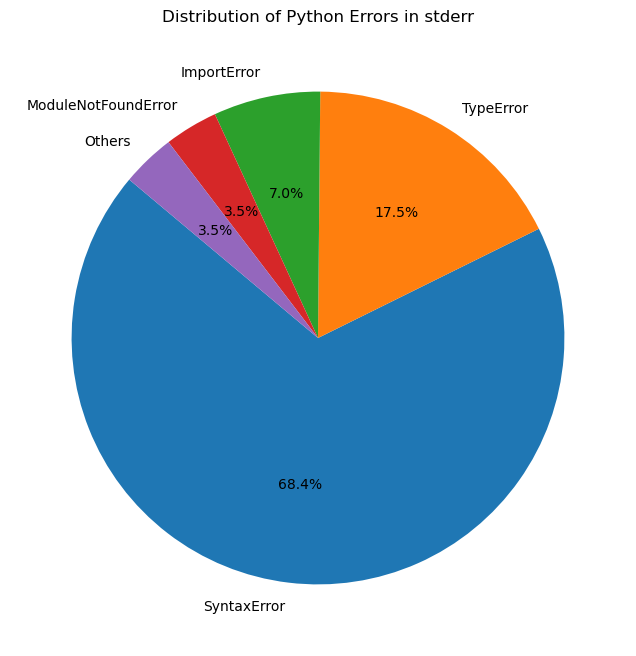

,Error Type,Count
0,SyntaxError,39
1,TypeError,10
2,ImportError,4
3,ModuleNotFoundError,2
4,NameError,1
5,ZeroDivisionError,1
6,RecursionError,0
7,PermissionError,0
8,UnboundLocalError,0
9,StopIteration,0


In [8]:
gemini_results_1 = get_normalized_df("/Users/vrucodes/CodeRefineAI/llm/RQ2/Gemini_SelfFeeback/Output_Results/Evaluation_Results/executed_refinement3_evaluation.json")
get_submission_status_charts(gemini_results_1)
analyze_runtime_errors(gemini_results_1)

In [9]:
gemini_codegen_file_1 = "/Users/vrucodes/CodeRefineAI/llm/RQ2/Gemini_SelfFeeback/Output_Results/Evaluation_Results/executed_refinement3_evaluation.json"
gemini_diff_with_rt_eff = get_diff(gemini_codegen_file_1,REFERENCE_FILE_RT_EFF)
gemini_diff_with_rt_ineff = get_diff(gemini_codegen_file_1,REFERENCE_FILE_RT_INEFF)


print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", gemini_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", gemini_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

print("\nCategorized Runtime Faster Solutions by Difficulty (Efficient Reference):")
print(gemini_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Difficulty (Inefficient Reference):")
print(gemini_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Topics (Efficient Reference):")
print(gemini_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Topics (Inefficient Reference):")
print(gemini_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 81.52173913043478
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 97.84946236559139

Categorized Runtime Faster Solutions by Difficulty (Efficient Reference):
difficulty  percentage_runtime_faster_solutions
      Easy                            68.750000
      Hard                            76.666667
    Medium                           100.000000

Categorized Runtime Faster Solutions by Difficulty (Inefficient Reference):
difficulty  percentage_runtime_faster_solutions
      Easy                               96.875
      Hard                              100.000
    Medium                               96.875

Categorized Runtime Faster Solutions by Topics (Efficient Reference):
             topics  percentage_runtime_faster_solutions
              array                            90.243902
       backtracking                             0.000000
   bit-manipulation       

/var/folders/sn/0y2q5txd5mn2ky3wvtpqbhwh0000gn/T/ipykernel_75751/3381018600.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  categorized_rt_faster_solutions_by_topics = rt_faster_solutions_df.groupby(['topics']).apply(lambda x: (x['faster_solution'] == 'codegen').sum() / len(x) * 100).reset_index(name='percentage_runtime_faster_solutions')
/var/folders/sn/0y2q5txd5mn2ky3wvtpqbhwh0000gn/T/ipykernel_75751/3381018600.py:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly sele

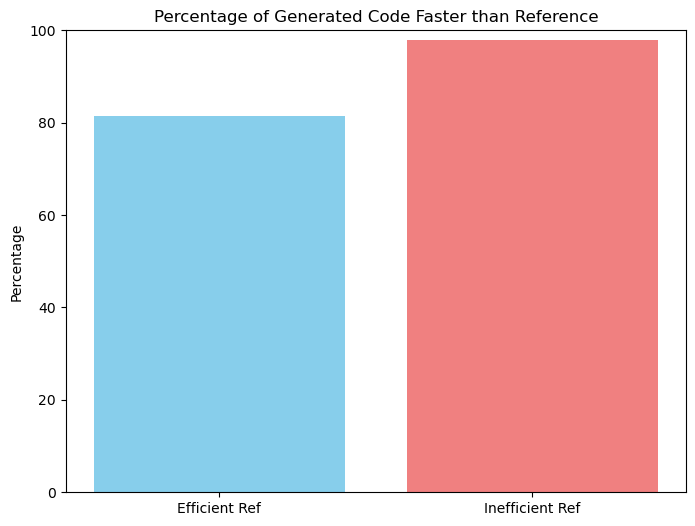

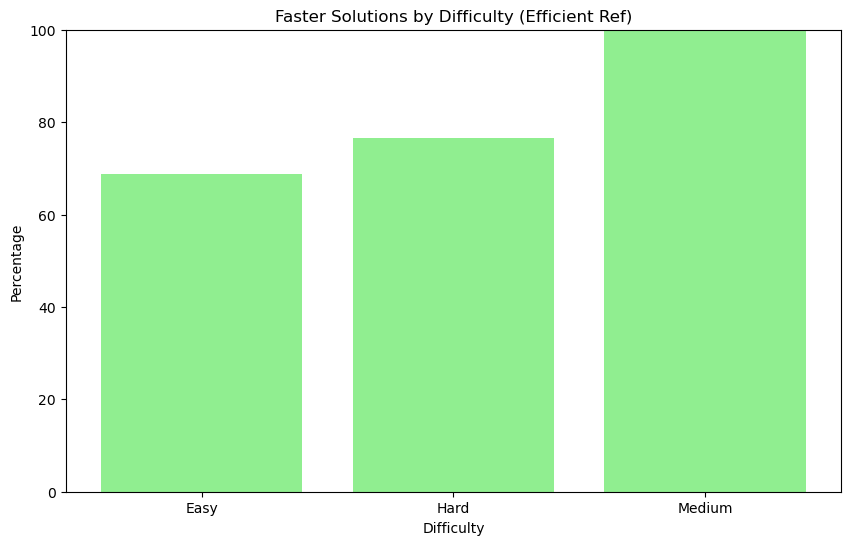

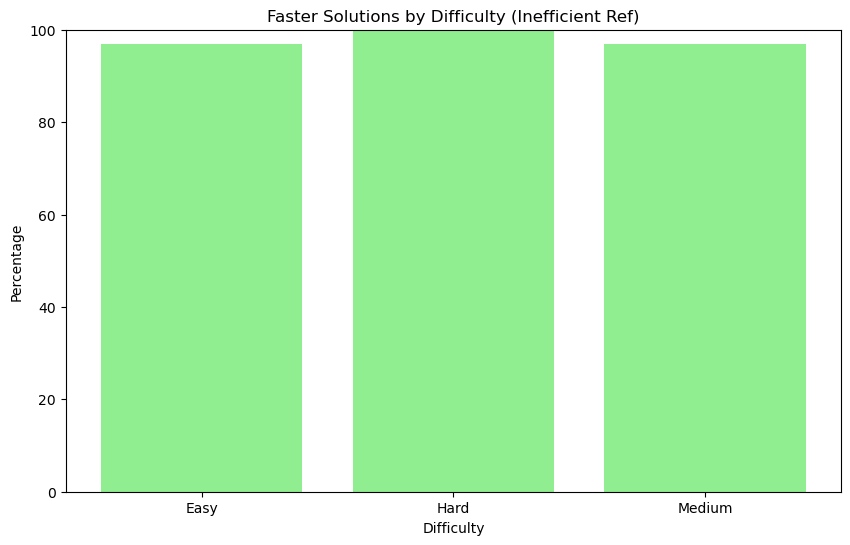

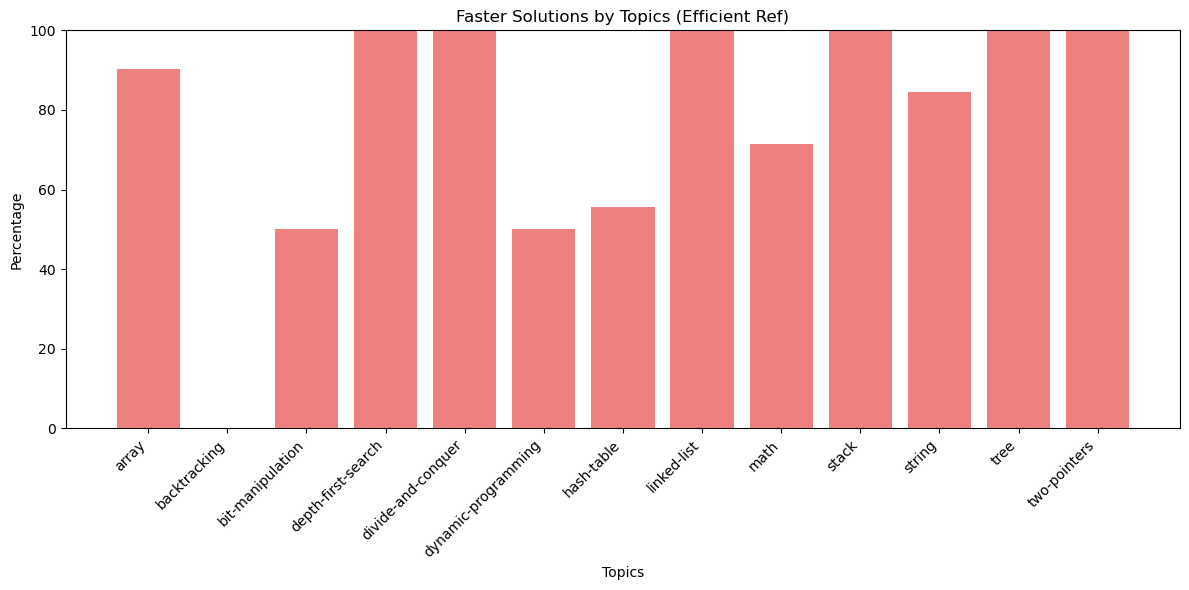

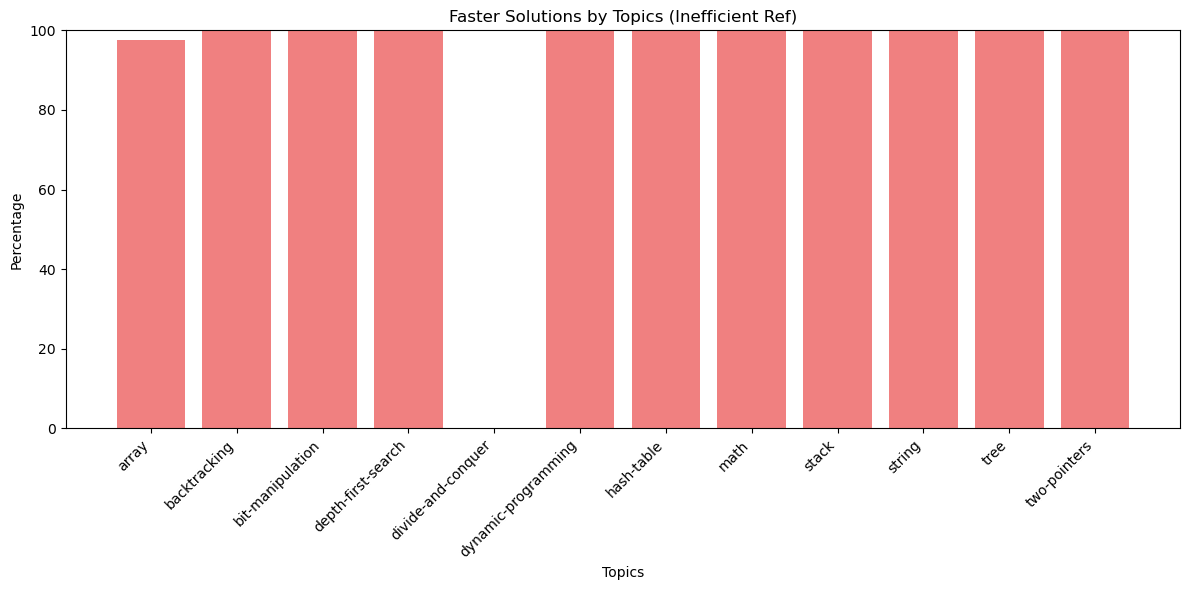

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have gemini_diff_with_rt_eff and gemini_diff_with_rt_ineff already calculated

# 1.1 Percentage of Faster Solutions:

labels = ['Efficient Ref', 'Inefficient Ref']
percentages = [gemini_diff_with_rt_eff["percentage_runtime_faster_solutions"],
               gemini_diff_with_rt_ineff["percentage_runtime_faster_solutions"]]

plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['skyblue', 'lightcoral'])
plt.ylabel('Percentage')
plt.title('Percentage of Generated Code Faster than Reference')
plt.ylim(0, 100)  # Set y-axis limit to 0-100
plt.show()


# 1.2 Categorized by Difficulty:

def plot_categorized_results(df, title):
    """Helper function to plot categorized results."""
    plt.figure(figsize=(10, 6))
    plt.bar(df['difficulty'], df['percentage_runtime_faster_solutions'], color='lightgreen')
    plt.xlabel('Difficulty')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.ylim(0, 100)
    plt.show()

plot_categorized_results(gemini_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"],
                         "Faster Solutions by Difficulty (Efficient Ref)")
plot_categorized_results(gemini_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"],
                         "Faster Solutions by Difficulty (Inefficient Ref)")


# 1.3 Categorized by Topics:

def plot_categorized_results_topics(df, title):
    """Helper function to plot categorized results for topics."""
    plt.figure(figsize=(12, 6))  # Adjust figure size for more topics
    plt.bar(df['topics'], df['percentage_runtime_faster_solutions'], color='lightcoral')
    plt.xlabel('Topics')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate topic labels for readability
    plt.ylim(0, 100)
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

plot_categorized_results_topics(gemini_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"],
                                 "Faster Solutions by Topics (Efficient Ref)")
plot_categorized_results_topics(gemini_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"],
                                 "Faster Solutions by Topics (Inefficient Ref)")

### LLAMA ANALYSIS

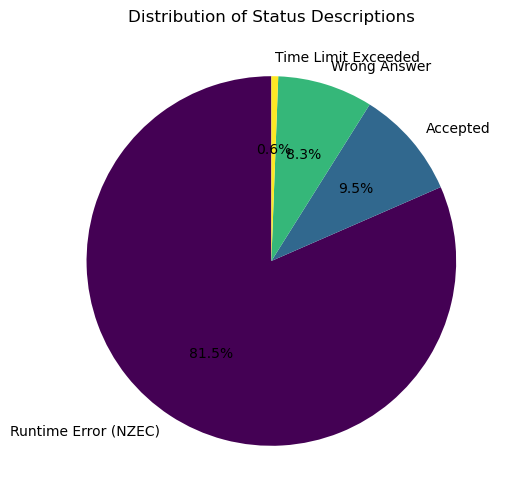

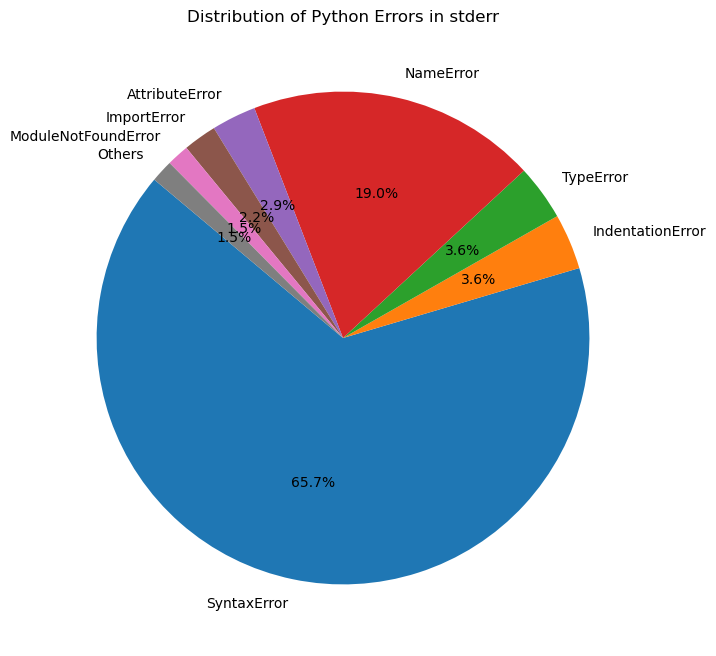

,Error Type,Count
0,SyntaxError,90
1,NameError,26
2,TypeError,5
3,IndentationError,5
4,AttributeError,4
5,ImportError,3
6,ModuleNotFoundError,2
7,KeyError,1
8,ValueError,1
9,NotImplementedError,0


In [7]:
llama_results_1 = get_normalized_df("/Users/vrucodes/CodeRefineAI/llm/RQ2/MetaLlama_SelfFeedback_Loop/Output_Results/Evaluation_Reslts/executed_refinement3_evaluation.json")
get_submission_status_charts(llama_results_1)
analyze_runtime_errors(llama_results_1)

In [8]:
llama_codegen_file_1 = "/Users/vrucodes/CodeRefineAI/llm/RQ2/MetaLlama_SelfFeedback_Loop/Output_Results/Evaluation_Reslts/executed_refinement3_evaluation.json"
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1,REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1,REFERENCE_FILE_RT_INEFF)


print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", llama_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

print("\nCategorized Runtime Faster Solutions by Difficulty (Efficient Reference):")
print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Difficulty (Inefficient Reference):")
print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Topics (Efficient Reference):")
print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Topics (Inefficient Reference):")
print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 62.5
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 93.75

Categorized Runtime Faster Solutions by Difficulty (Efficient Reference):
difficulty  percentage_runtime_faster_solutions
      Easy                            62.500000
      Hard                            57.142857
    Medium                           100.000000

Categorized Runtime Faster Solutions by Difficulty (Inefficient Reference):
difficulty  percentage_runtime_faster_solutions
      Easy                                 87.5
      Hard                                100.0
    Medium                                100.0

Categorized Runtime Faster Solutions by Topics (Efficient Reference):
            topics  percentage_runtime_faster_solutions
             array                            66.666667
      backtracking                             0.000000
divide-and-conquer                           100.00000

/var/folders/sn/0y2q5txd5mn2ky3wvtpqbhwh0000gn/T/ipykernel_93098/3381018600.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  categorized_rt_faster_solutions_by_topics = rt_faster_solutions_df.groupby(['topics']).apply(lambda x: (x['faster_solution'] == 'codegen').sum() / len(x) * 100).reset_index(name='percentage_runtime_faster_solutions')
/var/folders/sn/0y2q5txd5mn2ky3wvtpqbhwh0000gn/T/ipykernel_93098/3381018600.py:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly sele

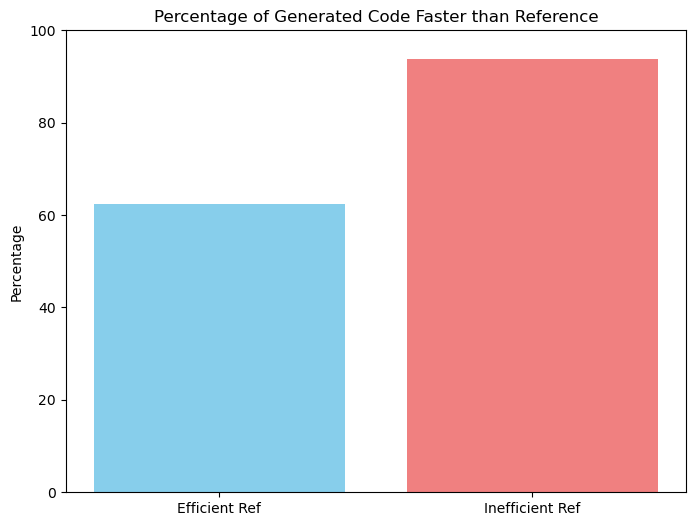

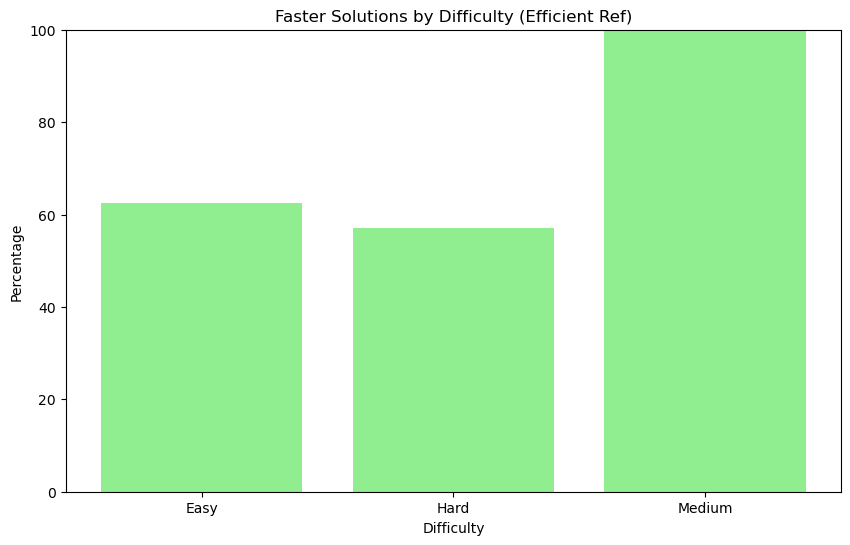

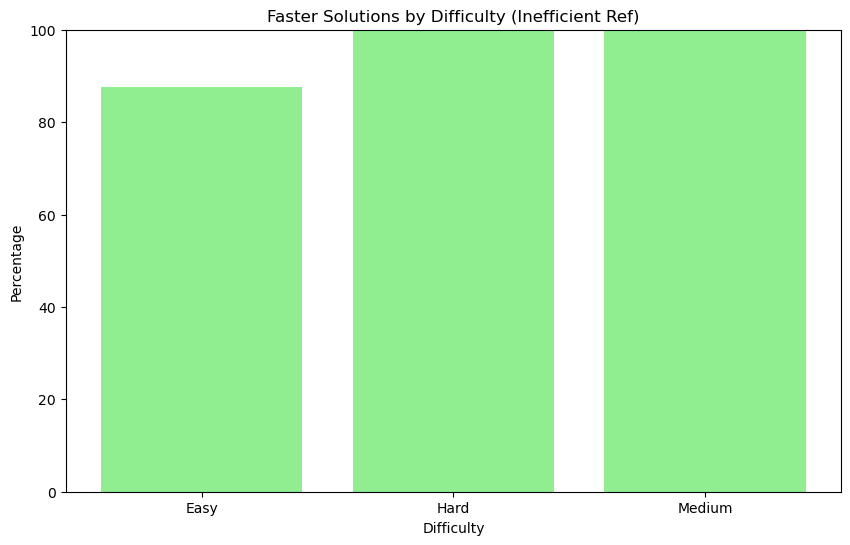

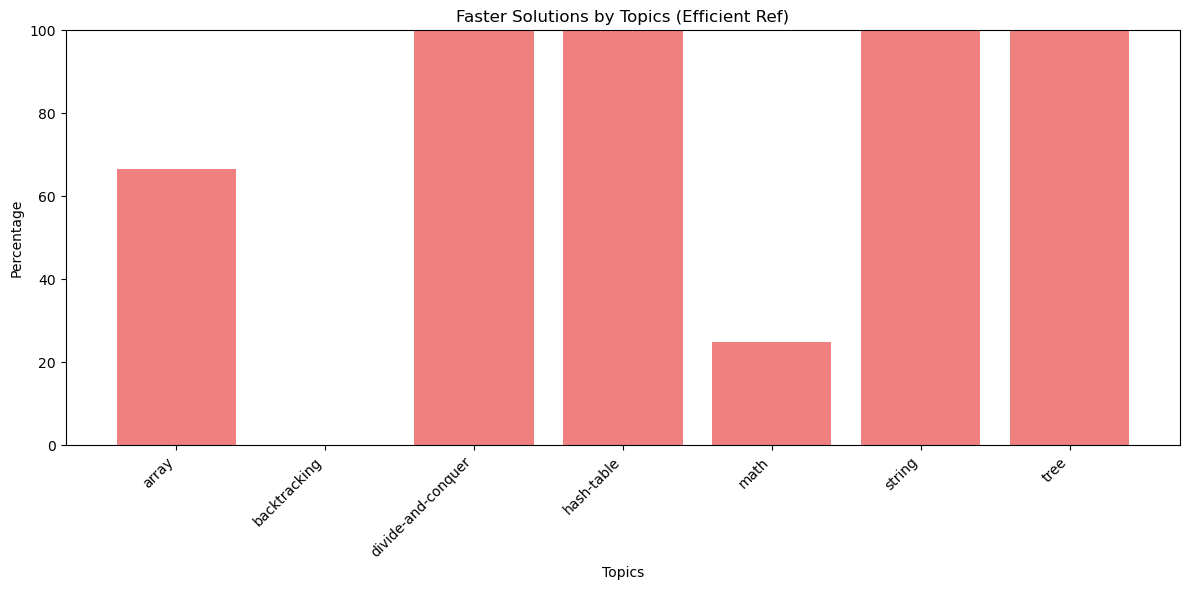

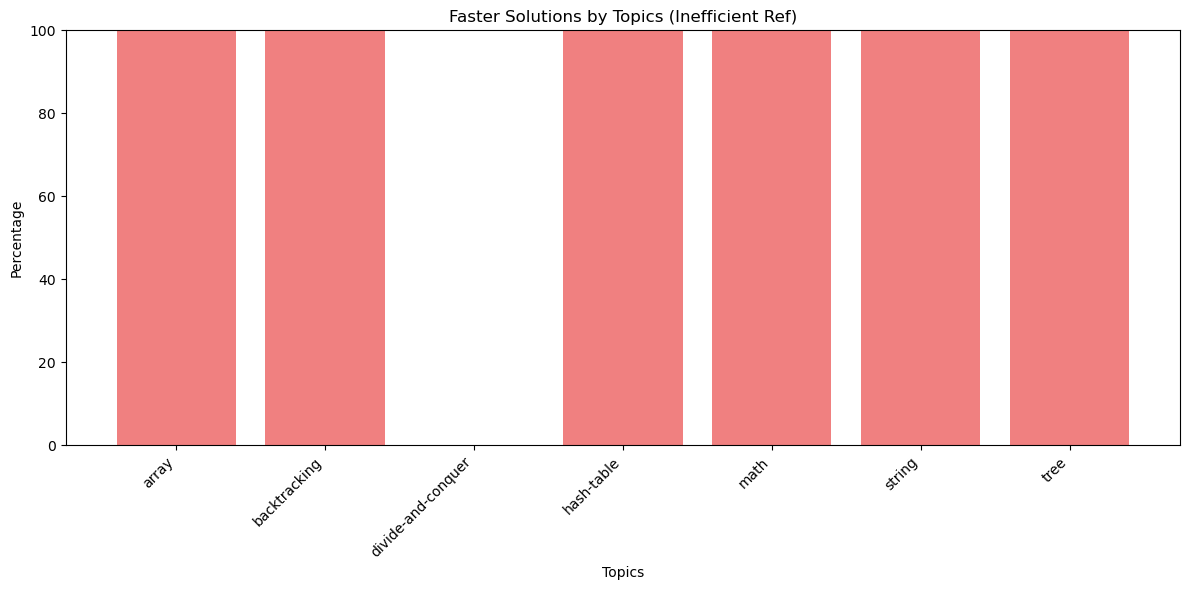

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have gemini_diff_with_rt_eff and gemini_diff_with_rt_ineff already calculated

# 1.1 Percentage of Faster Solutions:

labels = ['Efficient Ref', 'Inefficient Ref']
percentages = [llama_diff_with_rt_eff["percentage_runtime_faster_solutions"],
               llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"]]

plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['skyblue', 'lightcoral'])
plt.ylabel('Percentage')
plt.title('Percentage of Generated Code Faster than Reference')
plt.ylim(0, 100)  # Set y-axis limit to 0-100
plt.show()


# 1.2 Categorized by Difficulty:

def plot_categorized_results(df, title):
    """Helper function to plot categorized results."""
    plt.figure(figsize=(10, 6))
    plt.bar(df['difficulty'], df['percentage_runtime_faster_solutions'], color='lightgreen')
    plt.xlabel('Difficulty')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.ylim(0, 100)
    plt.show()

plot_categorized_results(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"],
                         "Faster Solutions by Difficulty (Efficient Ref)")
plot_categorized_results(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"],
                         "Faster Solutions by Difficulty (Inefficient Ref)")


# 1.3 Categorized by Topics:

def plot_categorized_results_topics(df, title):
    """Helper function to plot categorized results for topics."""
    plt.figure(figsize=(12, 6))  # Adjust figure size for more topics
    plt.bar(df['topics'], df['percentage_runtime_faster_solutions'], color='lightcoral')
    plt.xlabel('Topics')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate topic labels for readability
    plt.ylim(0, 100)
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

plot_categorized_results_topics(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"],
                                 "Faster Solutions by Topics (Efficient Ref)")
plot_categorized_results_topics(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"],
                                 "Faster Solutions by Topics (Inefficient Ref)")